# Madrid pollution data extraction and cleaning

### Goal:

This project goal is to extract public data information about pollution in Madrid, clean it and add data that makes sense if there are missing values, using Python programming language. The source is [this Madrid council webpage](https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=f3c0f7d512273410VgnVCM2000000c205a0aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default). We will download data for 2018. This data is real time hourly data. In this case we will just keep the NO2 agent.

### Steps:

In this Jupyter Notebook the next steps are taken:

* Downloading the data ([2018 real time data url](https://datos.madrid.es/egob/catalogo/201200-10306314-calidad-aire-horario.zip)), which comes in a zip folder with a file for each month in 3 different formats (.txt, .csv and .xml). In this case we will use the .csv extension files.

* Extracting just the .csv files from the zip folder.

* Adding records for missing days.

* Transforming the monthly dataframe, as the default format is not good to work with. There is a row for each day, with a column for each hour in the day, and another column for each hour to tell if that value is validated or not. In the transformed dataframe, we will have a column for hours and another one to indicate if that record is validated or not.

* Filling  non validated hour values. We assign the average of the previous validated value and the next validated value.

* Adding columns for year-month-date and year-month-date-time.

* Finally we append all the monthly files together to have a yearly file.

* Some tests to check if the transformation has been satisfactory.

* Some data exploration.

* Some charts to see visualized data.

In [1]:
import urllib.request
from zipfile import ZipFile
import pandas as pd
import numpy as np
import calendar
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def download_from_url(url, file_name):
    '''Downloads data from a url and stores it in the location where it is executed.'''
    urllib.request.urlretrieve(url, file_name)

In [3]:
def extract_from_zip_folder(file_type, zip_folder_path, new_folder_path):
    '''This function extracts files from a zip folder.
    It just extracts the files of a certain type
    '''
    with ZipFile(zip_folder_path, 'r') as zip_obj:
        # Gets a list of all archived file names from the zip.
        list_of_file_names = zip_obj.namelist()
        # Iterates over the file names.
        for file_name in list_of_file_names:
            # Checks filename endswith the required file type.
            if file_name.endswith(f'.{file_type}'):
                # Extracts a single file from zip.
                print(f'extracting {file_name}')
                zip_obj.extract(file_name, new_folder_path)

In [4]:
def add_missing_days(dataframe, partition_column):
    '''This function takes the monthly dataframe and checks if there are missing days
    for a specific sample spot. If so, it appends a row to the original dataframe with
    the info of that day and the validation columns set to N (non validated), to know that
    info is not correct (we will correct it later).
    '''
    year = dataframe.loc[0, 'ANO']
    month = dataframe.loc[0, 'MES']
    
    # First we have to know how many days a specific month has.
    _, number_days_month = calendar.monthrange(year, month)
    
    # We create a list with all the days of that month.
    list_of_days_of_the_month = list(range(1, number_days_month + 1))
    
    # We create a list with all the sample spots.
    sample_spots_list = list(set(dataframe[partition_column]))
    
    for sample_spot in sample_spots_list:
        # We create a df with just the info of one spot.
        sample_spot_df = dataframe[
            dataframe[partition_column] == sample_spot].reset_index(drop=True)

        # We check if all that days are contained in the spot df.
        isin_df = pd.Series(list_of_days_of_the_month).isin(list(sample_spot_df['DIA']))
        isin_df.index = list_of_days_of_the_month

        # Now, if a day is not included, we append a row with its data to the original df.
        for day, isin in isin_df.iteritems():
            if isin == False:
                print(f'Day {day}-{month}-{year} missing')
                
                # We take the first row of the df, but we change the day and the
                # validation columns to 'N'.
                row_to_append = [
                    sample_spot_df.loc[0, column] for column in sample_spot_df.columns]
                row_to_append[6] = day
                for i, e in enumerate(row_to_append):
                    if e == 'V':
                        row_to_append[i] = 'N'
                
                # We append the row.
                dataframe = dataframe.append(
                    pd.Series(row_to_append, index=sample_spot_df.columns),
                    ignore_index=True
                )
                
                print(f'Day {day}-{month}-{year} row added to original dataframe')
            
    return dataframe

In [5]:
def get_stacked_dataframe(dataframe, cols_to_drop, cols_remain):
    '''This function applies the pandas stack method to make data that is
    spread in columns collapse in a single column.
    First drops the columns that would not let the stack work properly,
    as we want to have the columns that will remain as they are,
    and the columns that will be stacked in the same column.
    Then sets the columns that do not have to be stacked as the index.
    Applies stack method. Finally, resets index.
    '''
    dataframe = dataframe.drop(columns=cols_to_drop).set_index(cols_remain)
    dataframe = dataframe.stack().reset_index()
    dataframe = dataframe[dataframe[dataframe.columns[-2]] != 'index']
    dataframe = dataframe.reset_index(drop=True)
    return dataframe

In [6]:
def add_last_col_to_df(df1, df2):
    ''' Adds the last column from a dataframe to another dataframe
    with the same number of rows.
    '''
    df1['new_col'] = df2.iloc[:,-1]
    return df1

In [7]:
def get_next_validated_value(dataframe, index, column, get_next=True):
    '''This function gets the nearest next or previous validated row index in a dataframe.
    If the get_next param is set to True, it looks for the nearest next validated row index,
    and if set to False, looks for the nearest previous validated row index.
    '''
    # We set a default initial values to start the iteration.
    iterator = 0
    next_validated = 'N'
    
    # The loop starts. It checks if the next (or previous) row value is V.
    # If it is V, the while loop breaks and returns the required index.
    # If it is not V, it checks the next (or previous) row, and so on until it finds a V.
    while next_validated != 'V':
        iterator += 1
        
        if get_next:
            next_validated = dataframe.loc[index + iterator, column]
            wanted_index = index + iterator
        else:
            next_validated = dataframe.loc[index - iterator, column]
            wanted_index = index - iterator

    return wanted_index

In [8]:
def assign_non_validated_values(dataframe, partition_column):
    '''This function partitions the dataframe by a partition column (PUNTO_MUESTREO)
    into smaller dataframes and, for each of them, sets new values to non validated records,
    based on near values. It tries to get the nearest next and previous validated values,
    to assign an average of them. If it doesn't find a nearest next validated value,
    it assigns the nearest previous one, and viceversa.
    '''
    # First we sort the data.
    dataframe = dataframe.sort_values(by=['PUNTO_MUESTREO', 'ANO', 'MES', 'DIA', 'HORA'])
    dataframe = dataframe.reset_index(drop=True)
    
    # We get a list of the partition_column unique values, to loop through them.
    sample_spots_list = list(set(dataframe[partition_column]))
    
    # We start the loop.
    for sample_spot in sample_spots_list:
        
        # We get the partitioned dataframe.
        sample_spot_df = dataframe[dataframe[partition_column] == sample_spot]
        
        # Now we assign the non validated records to a new dataframe.
        sample_spot_df_n = sample_spot_df[sample_spot_df['VALIDADO'] == 'N']
        
        # We loop over the non validated records dataframe.
        for index, row in sample_spot_df_n.iterrows():            
            
            # We try to get the next nearest validated value in the original df.
            try:
                next_validated_index = get_next_validated_value(
                    sample_spot_df, index, 'VALIDADO')
                
                # Now we try to get the previous nearest validated value.
                try:
                    previous_validated_index = get_next_validated_value(
                        sample_spot_df, index, 'VALIDADO', get_next=False)
                    dataframe.loc[index, 'NIVEL_NO2'] = (
                        sample_spot_df.loc[next_validated_index, 'NIVEL_NO2'] +
                        sample_spot_df.loc[previous_validated_index, 'NIVEL_NO2']
                    ) / 2
                
                # I we reach this point, it means that there are validated values in
                # the next rows, but there are not any validated values in the
                # previous rows, so we assign the nearest next validated value.
                except KeyError:
                    next_validated_index = get_next_validated_value(
                        sample_spot_df, index, 'VALIDADO')
                    dataframe.loc[index, 'NIVEL_NO2'] = sample_spot_df.loc[
                        next_validated_index, 'NIVEL_NO2']
            
            # I we reach this point, it means that there are validated values in the
            # previous rows, but there are not any validated values in the next rows,
            # so we assign the nearest previous validated value.
            except KeyError:
                next_validated_index = get_next_validated_value(
                    sample_spot_df, index, 'VALIDADO', get_next=False)
                dataframe.loc[index, 'NIVEL_NO2'] = sample_spot_df.loc[
                    next_validated_index, 'NIVEL_NO2']
                
            # For now, we asume that there will always be at least either a
            # next validated value or a previous validated value.
            
            # So far, the 'VALIDADO' column can contain either V if it is a validated
            # value or an N if it is not. To confirm that we have assigned a value that
            # we think makes sense, we change that value to an R (Reassign).
            dataframe.loc[index, 'VALIDADO'] = 'R'

    return dataframe

In [9]:
def int_date_to_string(integer):
    '''It turns 1 to 9 integers into strings with a '0' before, and keeps
    the same the rest of numbers.
    '''
    if len(str(integer)) == 1:
        return '0' + str(integer)
    else:
        return str(integer)

In [10]:
def get_clean_df(dataframe):
    '''Gets a df, keeps just the NO2 info, splits it into 2 dataframes,
    each of them with one of the columns that we want to stack,
    joins them into a single dataframe, renames columns and formats HORA column.
    The result is a much easier to use dataframe'''
        
    print('Keeping just NO2 data.')
    dataframe = dataframe[dataframe['MAGNITUD'] == 8].drop(columns=['MAGNITUD'])
    dataframe = dataframe.reset_index(drop=True)
        
    print('Adding missing days rows.')
    # We need a list of the sample spots.
    list_of_sample_spots = list(set(dataframe['PUNTO_MUESTREO']))
    
    # We apply the function that add records of missing days.
    dataframe = add_missing_days(dataframe, 'PUNTO_MUESTREO')
        
    cols_dimensiones = ['PROVINCIA', 'MUNICIPIO', 'ESTACION',
                        'PUNTO_MUESTREO', 'ANO', 'MES', 'DIA']
    
    print('Stacking dataframes.')
    df_h = get_stacked_dataframe(
        dataframe, cols_remain=cols_dimensiones,
        cols_to_drop=[col for col in list(dataframe.columns) if col[0] == 'V']
    )
    
    df_v = get_stacked_dataframe(
        dataframe, cols_remain=cols_dimensiones,
        cols_to_drop=[col for col in list(dataframe.columns) if col[0] == 'H']
    )
    
    print('Joining dataframes.')
    final_df = add_last_col_to_df(df_h, df_v)
    
    print('Renaming columns.')
    final_df = final_df.rename(columns={'level_7': 'HORA', 0: 'NIVEL_NO2',
                                        'new_col': 'VALIDADO'})
    
    print('Formatting HORA column.')
    final_df['HORA'] = final_df['HORA'].apply(lambda x: int(x[-2:]))
    
    print('Assigning values to non validated records.')
    final_df = assign_non_validated_values(final_df, 'PUNTO_MUESTREO')
    
    print('Adding date and time columns.')
    final_df['ANO_MES_DIA'] = (
        final_df['ANO'].astype(str) +
        final_df['MES'].apply(int_date_to_string) +
        final_df['DIA'].apply(int_date_to_string)
    ).astype(int)
    
    final_df['ANO_MES_DIA_HORA'] = (
        final_df['ANO'].astype(str) +
        final_df['MES'].apply(int_date_to_string) +
        final_df['DIA'].apply(int_date_to_string) +
        final_df['HORA'].apply(int_date_to_string)
    ).astype(int)
    
    print('Reordering columns.')
    final_df = final_df[[
        'PROVINCIA', 'MUNICIPIO', 'ESTACION', 'PUNTO_MUESTREO', 'ANO', 'MES', 'DIA',
        'HORA', 'ANO_MES_DIA', 'ANO_MES_DIA_HORA', 'NIVEL_NO2', 'VALIDADO'
    ]]
    
    print(f'Monthly dataframe shape: {final_df.shape}.')
    print()
    
    return final_df

In [11]:
def get_complete_dataframe(url, file_name, desired_data_path, file_type):
    '''This last function of the process executes the other built functions.
    It downloads the zip folder, extracts just the required files by format,
    accesses each of the files, transforms them in pandas dataframes, cleans, adds
    missing values, and appends all the dataframes together.
    '''
    
    # We download the file with the data.
    download_from_url(url, file_name)
    
    # Extraction of just the wanted files (.csv).
    extract_from_zip_folder(file_type, file_name, desired_data_path)
    
    # We create an empty dataframe to append the clean ones to it in each loop iteration.
    data = pd.DataFrame()
    
    # We iterate through the files.
    for file_name in os.listdir(desired_data_path):
        print()
        print(f'Working with {file_name}')
        
        # We convert the csv files into dataframes.
        
        # For Windows:
        try:
            monthly_data = pd.read_csv(f'{desired_data_path}/{file_name}', sep=';')
        
        # For Linux:
        except:
            monthly_data = pd.read_csv(f'{desired_data_path}\\{file_name}', sep=';')

        # We pass the monthly dataframe to the cleaning function.
        monthly_data = get_clean_df(monthly_data)
        
        # We append the clean monthly dataframe to the final dataframe.
        data = data.append(monthly_data, ignore_index=True)
        
    print(f'Final dataframe shape: {data.shape}')
    
    return data

In [12]:
# Final execution.
if __name__ == '__main__':

    url = 'https://datos.madrid.es/egob/catalogo/201200-10306314-calidad-aire-horario.zip'
    file_name = 'pollution_data.zip'
    file_type = 'csv'
    desired_data_path = f'pollution_data_{file_type}'

    final_df = get_complete_dataframe(url, file_name, desired_data_path, file_type)

extracting abr_mo18.csv
extracting ago_mo18.csv
extracting dic_mo18.csv
extracting ene_mo18.csv
extracting feb_mo18.csv
extracting jul_mo18.csv
extracting jun_mo18.csv
extracting mar_mo18.csv
extracting may_mo18.csv
extracting nov_mo18.csv
extracting oct_mo18.csv
extracting sep_mo18.csv

Working with abr_mo18.csv
Keeping just NO2 data.
Adding missing days rows.
Day 18-4-2018 missing
Day 18-4-2018 row added to original dataframe
Stacking dataframes.
Joining dataframes.
Renaming columns.
Formatting HORA column.
Assigning values to non validated records.
Adding date and time columns.
Reordering columns.
Monthly dataframe shape: (17280, 12).


Working with ago_mo18.csv
Keeping just NO2 data.
Adding missing days rows.
Day 3-8-2018 missing
Day 3-8-2018 row added to original dataframe
Day 4-8-2018 missing
Day 4-8-2018 row added to original dataframe
Day 5-8-2018 missing
Day 5-8-2018 row added to original dataframe
Stacking dataframes.
Joining dataframes.
Renaming columns.
Formatting HORA colu

In [13]:
final_df.head(10)

,PROVINCIA,MUNICIPIO,ESTACION,PUNTO_MUESTREO,ANO,MES,DIA,HORA,ANO_MES_DIA,ANO_MES_DIA_HORA,NIVEL_NO2,VALIDADO
0,28,79,4,28079004_8_8,2018,4,1,1,20180401,2018040101,21.0,V
1,28,79,4,28079004_8_8,2018,4,1,2,20180401,2018040102,19.0,V
2,28,79,4,28079004_8_8,2018,4,1,3,20180401,2018040103,17.0,V
3,28,79,4,28079004_8_8,2018,4,1,4,20180401,2018040104,24.0,V
4,28,79,4,28079004_8_8,2018,4,1,5,20180401,2018040105,17.0,V
5,28,79,4,28079004_8_8,2018,4,1,6,20180401,2018040106,35.0,V
6,28,79,4,28079004_8_8,2018,4,1,7,20180401,2018040107,40.0,V
7,28,79,4,28079004_8_8,2018,4,1,8,20180401,2018040108,36.0,V
8,28,79,4,28079004_8_8,2018,4,1,9,20180401,2018040109,34.0,V
9,28,79,4,28079004_8_8,2018,4,1,10,20180401,2018040110,35.0,V


### Some checks:

In [14]:
# Let's take a look at how the raw info is downloaded, and compare it the result.
file_type = 'csv'
desired_data_path = f'pollution_data_{file_type}'

sample_file_name = os.listdir(desired_data_path)[0]

# We convert the csv files into dataframes.

# For Windows:
try:
    monthly_data = pd.read_csv(f'{desired_data_path}/{sample_file_name}', sep=';')

# For Linux:
except:
    monthly_data = pd.read_csv(f'{desired_data_path}\\{sample_file_name}', sep=';')
    
monthly_data.head(10)

,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,H01,V01,...,H20,V20,H21,V21,H22,V22,H23,V23,H24,V24
0,28,79,4,1,28079004_1_38,2018,4,1,2.0,V,...,2.0,V,2.0,V,3.0,V,4.0,V,3.0,V
1,28,79,4,1,28079004_1_38,2018,4,2,2.0,V,...,2.0,V,2.0,V,2.0,V,2.0,V,2.0,V
2,28,79,4,1,28079004_1_38,2018,4,3,2.0,V,...,2.0,V,2.0,V,2.0,V,2.0,V,2.0,V
3,28,79,4,1,28079004_1_38,2018,4,4,2.0,V,...,2.0,V,2.0,V,2.0,V,2.0,V,2.0,V
4,28,79,4,1,28079004_1_38,2018,4,5,2.0,V,...,2.0,V,2.0,V,4.0,V,5.0,V,4.0,V
5,28,79,4,1,28079004_1_38,2018,4,6,3.0,V,...,2.0,V,3.0,V,3.0,V,2.0,V,2.0,V
6,28,79,4,1,28079004_1_38,2018,4,7,2.0,V,...,2.0,V,2.0,V,2.0,V,2.0,V,2.0,V
7,28,79,4,1,28079004_1_38,2018,4,8,2.0,V,...,2.0,V,2.0,V,2.0,V,2.0,V,2.0,V
8,28,79,4,1,28079004_1_38,2018,4,9,2.0,V,...,2.0,V,2.0,V,2.0,V,1.0,V,1.0,V
9,28,79,4,1,28079004_1_38,2018,4,10,1.0,V,...,2.0,V,2.0,V,1.0,V,1.0,V,1.0,V


In [15]:
# Number of records per month. If we divide the total number of records by the number
# of sample spots and by 24 hours in a day, we will get the number of days a month has.
number_of_sample_spots = len(set(final_df['PUNTO_MUESTREO']))
number_of_hours_in_a_day = 24

final_df['MES'].value_counts().apply(
    lambda x: int(x / number_of_sample_spots / number_of_hours_in_a_day)
).sort_index()

1     31
2     28
3     31
4     30
5     31
6     30
7     31
8     31
9     30
10    31
11    30
12    31
Name: MES, dtype: int64

In [16]:
# Let´s check how many records we have corrected because they were not validated.
print(final_df['VALIDADO'].value_counts())

V    209081
R      1159
Name: VALIDADO, dtype: int64


### Some charts:

In [17]:
# Let's see how the pollution evolves in the year.
# This dataframe shows the minimum, average and maximum NO2 levels per month.
monthly = pd.pivot_table(
    data=final_df, index=['MES'], values='NIVEL_NO2', aggfunc=[min, np.mean, max]
)

monthly.columns = monthly.columns.droplevel()
monthly = monthly.reset_index().sort_values('MES')
monthly.columns = ['MES', 'MIN_NO2', 'AVG_NO2', 'MAX_NO2']

monthly

,MES,MIN_NO2,AVG_NO2,MAX_NO2
0,1,1.0,48.690356,276.0
1,2,1.0,45.829737,202.0
2,3,1.0,29.487875,144.0
3,4,1.0,31.050781,168.0
4,5,1.0,29.377072,150.0
5,6,1.0,27.129601,184.0
6,7,1.0,27.480231,199.0
7,8,1.0,28.798919,273.0
8,9,1.0,37.609288,240.0
9,10,1.0,39.774082,308.0


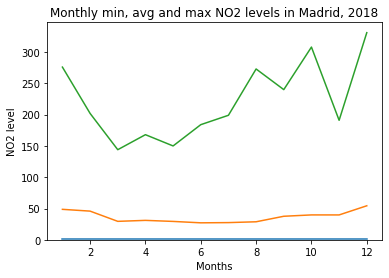

In [18]:
# Monthly min, avg and max NO2 levels in Madrid, 2018 line chart.
plt.plot(monthly['MES'], monthly['MIN_NO2'])
plt.plot(monthly['MES'], monthly['AVG_NO2'])
plt.plot(monthly['MES'], monthly['MAX_NO2'])

plt.ylim(ymin=0)

plt.xlabel('Months')
plt.ylabel('NO2 level')
plt.title('Monthly min, avg and max NO2 levels in Madrid, 2018')

plt.show()

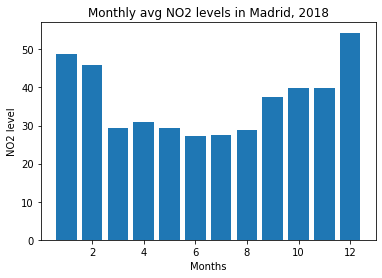

In [19]:
# Monthly avg NO2 levels in Madrid, 2018 bar chart.
plt.bar(monthly['MES'], monthly['AVG_NO2'])
plt.ylim(ymin=0)

plt.xlabel('Months')
plt.ylabel('NO2 level')
plt.title('Monthly avg NO2 levels in Madrid, 2018')

plt.show()

In [20]:
# Let's see how the pollution evolves depending on the time of the day.
# This dataframe shows the minimum, average and maximum NO2 levels per hour.
hourly = pd.pivot_table(
    data=final_df, index=['HORA'], values='NIVEL_NO2', aggfunc=[min, np.mean, max]
)

hourly.columns = hourly.columns.droplevel()
hourly = hourly.reset_index().sort_values('HORA')
hourly.columns = ['HORA', 'MIN_NO2', 'AVG_NO2', 'MAX_NO2']

hourly

,HORA,MIN_NO2,AVG_NO2,MAX_NO2
0,1,1.0,38.478025,199.0
1,2,1.0,31.603938,166.0
2,3,1.0,25.945719,150.0
3,4,1.0,22.544578,140.0
4,5,1.0,21.169863,106.0
5,6,1.0,22.603881,110.0
6,7,1.0,30.228196,122.0
7,8,1.0,44.609075,145.0
8,9,1.0,51.367352,222.0
9,10,1.0,48.069635,214.0


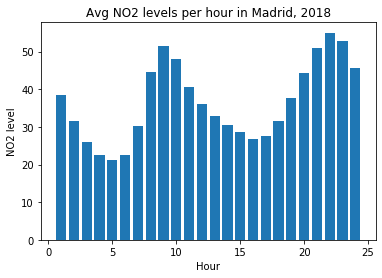

In [21]:
# Monthly avg NO2 levels in Madrid, 2018 bar chart.
plt.bar(hourly['HORA'], hourly['AVG_NO2'])
plt.ylim(ymin=0)

plt.xlabel('Hour')
plt.ylabel('NO2 level')
plt.title('Avg NO2 levels per hour in Madrid, 2018')

plt.show()

In [22]:
# This chart can say that the pollution level starts to grow at 6 AM, maybe
# because people start driving their cars from home to their jobs.
# Then, at 10, the measured levels start to fall.
# After, at 17, people start driving back home, so the level raises again,
# and then at 23 it starts falling again.